**The Calibration Algorithm**

The algorithm has two main steps (from Algorithm 1 listing in the paper):
1. Construct a recalibration dataset $\mathcal{D}$:
$$
\mathcal{D} = \left\{\left(\left[H\left(x_t\right)\right]\left(y_t\right), \hat P\left(\left[H\left(x_t\right)\right]\left(y_t\right)\right)\right)\right\}_{t=1}^T
$$
where $\hat P(p)=\left|\left\{y_t\mid \left[H\left(x_t\right)\right]\left(y_t\right)\lt p, t=1\ldots T\right\}\right|/T$.

2. Train a model $R$ on $\mathcal{D}$.

With the notations above, $T$ is the number of observations we have for our model. Each observation, $t \in 1\ldots T$, is a tuple $(y_t, x_t)$ with $x_t$ being the predictor(s).

$H(x_t)$ is the model output. The algorithm expects $H(x_t)$ to be a CDF of a proper probability distribution. In bayesian models, this correponds to the posterior predictive, converted to a CDF, and evaluated at a particular observation point, $x_t$.

**Implementation**

In practice, for complicated bayesian models, we do not have the analytical form of the posterior predictive CDF readily available. The values of posterior predictive are generated from the samples of the posterior. In these cases, we can compare the values of $y_t$ against the set of posterior predictive samples and obtain the percentiles.

Let us define the set of posterior predictive samples (using posterior samples and then evaluating at $x_t$) as $S_t=\left\{s_{t_n}\sim h(x_t)\right\}_{n=1}^N$, where $N$ is the number of posterior samples and $h(x_t)$ is the pdf of the posterior predictive at $x_t$.

Then, without closed form of the posterior predictive CDF, we can approximate $\left[H(x_t)\right](y_t)$ as:

$$
\widehat{\left[H(x_t)\right](y_t)} = \left|\left\{s_{t_n}\mid s_{t_n} \le y_t,n=1\ldots N\right\}\right|/N
$$

That is, we simply count the proportion of $s_{t_n}$ samples that are less than $y_t$. This gives the estimated percentile of $y_t$ at $x_t$ in the posterior predictive distribution.

After calculating $\widehat{\left[H(x_t)\right](y_t)}$ for all $t$ (all observations), we can then evaluate $\hat P$ directly for each $t$.

Effectively, our dataset for recalibration is constructed as:
$$
\mathcal{D} = \left\{\left(\widehat{\left[H\left(x_t\right)\right]\left(y_t\right)}, \hat P\left(\widehat{\left[H\left(x_t\right)\right]\left(y_t\right)}\right)\right)\right\}_{t=1}^T
$$

**Concrete Steps**

Concretely, for models without closed form posterior predictive CDF, the calibration algorithm is restated as:
1. Generate $N$ samples from the posterior, $\theta = \left\{\theta_n, n=1\ldots N\right\}$.
2. For each observation, $t \in 1\ldots T$
    * Generate $N$ samples of posterior predictive, $s_{t_n}$, from $\theta$, the posterior samples in step (1), evaluated at $x_t$
    * Let $p_t$ be the percentile of $y_t$. Estimate the percentile of $y_t$ as
    $$p_t = \widehat{\left[H(x_t)\right](y_t)} = \left|\left\{s_{t_n}\mid s_{t_n} \le y_t,n=1\ldots N\right\}\right|/N$$
3. For each $t$
    * calculate $\hat P\left(\widehat{\left[H\left(x_t\right)\right]\left(y_t\right)}\right) = \hat P\left(p_t\right)$ as
    $$\hat P\left(p_t\right) = \left|\left\{p_u\mid p_u\lt p_t, u=1\ldots T\right\}\right|/T
    $$
    That is, find the proportion of observations that have lower percentile values than that of the current observation.

4. Construct $\mathcal{D} = \left\{\left(\widehat{\left[H\left(x_t\right)\right]\left(y_t\right)}, \hat P\left(\widehat{\left[H\left(x_t\right)\right]\left(y_t\right)}\right)\right)\right\}_{t=1}^T$
5. Train calibration tranformation using $\mathcal{D}$ via isotonic regression (or other models)

**Possible use in calibration error metric:** This percentile approximation may also be used to as part of calculation of the calibration error metric as defined in equation (9) of the paper.

**Draft Implementation**

In [1]:
import warnings

import numpy as np
import pymc3 as pm
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)
plt.rc('figure', dpi=100)

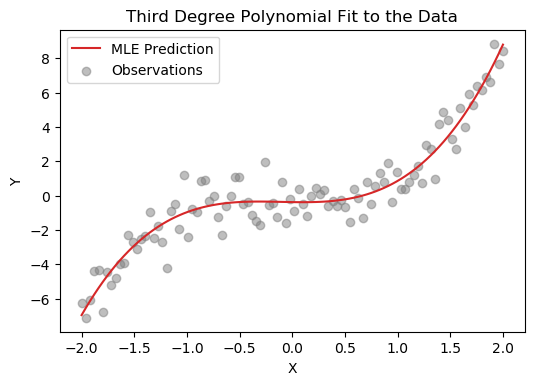

In [3]:
np.random.seed(0)

# Generate observations
x = np.linspace(-2, 2, num=100)
y = x**3 + np.random.normal(size=x.size)

# Create polynomial features: 1, X, X^2 and X^3
poly = PolynomialFeatures(degree=3)
X_train = poly.fit_transform(x[:, np.newaxis])

# Fit maximum likelihood polynomial regression just for illustration
coefs = np.polyfit(x, y, deg=3)[::-1]
y_pred = X_train @ coefs
plt.scatter(x, y, color='tab:grey', alpha=0.5, label='Observations')
plt.plot(x, y_pred, color='tab:red', label='MLE Prediction')
plt.gca().set(xlabel='X', ylabel='Y', title='Third Degree Polynomial Fit to the Data')
plt.legend();

A Bayesian polynomial regression model:
$$
a, b, c, d \sim \mathcal{N}(0, 1) \\
f(X) = a X^3 + b X^2 + c X + d \\
Y_{observed} \sim \mathcal{N}(f(X), 1)
$$

In [4]:
# Sample from the Bayesian polynomial regression, even though we could
# derive the posterior analytically.
with pm.Model() as model:
    coefs = pm.Normal('coefs', mu=0, sigma=1, shape=4)
    y_pred = pm.math.dot(X_train, coefs)
    y_obs = pm.Normal('y_obs', mu=y_pred, sigma=1, observed=y)
    
    # Obtain 2000 samples from the posterior (1000 * 2 chains)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [coefs]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1043.54draws/s]


In [5]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
coefs__0,-0.370399,0.153304,0.005369,-0.690510,-0.085886,759.323726,1.000015
coefs__1,-0.075722,0.207972,0.007419,-0.465104,0.323429,814.990557,0.999500
coefs__2,0.319258,0.083338,0.002803,0.162052,0.485618,888.916913,1.000120
coefs__3,1.001412,0.076793,0.002674,0.855150,1.151873,835.236639,0.999622


In [6]:
def simulate_posterior_predictive(x, coefs, noise):
    """Generate samples from the posterior predictive using a third degree
    polynomial and a supplied standard deviation of the noise.
    """
    x = x.reshape(-1, 1)
    X = PolynomialFeatures(degree=3).fit_transform(x)
    posterior_predictive = X @ coefs
    posterior_predictive += np.random.normal(loc=0, scale=noise, size=posterior_predictive.shape)
    return posterior_predictive

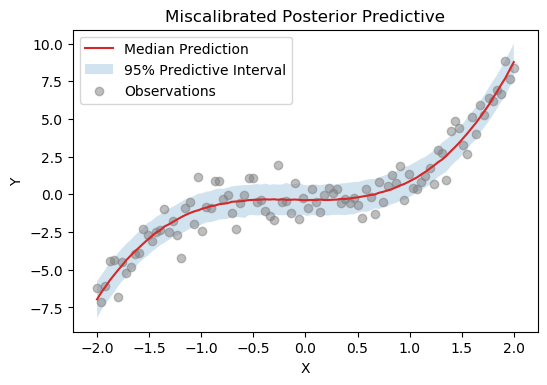

In [7]:
# Simulate the posterior predictive for 100 equally spaced values of x and
# noise of 0.5, which is lower than the true noise to cause miscalibration
x_test = np.linspace(x.min(), x.max(), num=100)
coefs = trace['coefs'].T
posterior_predictive = simulate_posterior_predictive(x_test, coefs, noise=0.5)

# Plot the posterior predictive
low, mid, high = np.percentile(posterior_predictive, [2.5, 50, 97.5], axis=1)
plt.fill_between(x_test, low, high, alpha=0.2, label='95% Predictive Interval')
plt.plot(x_test, mid, color='tab:red', label='Median Prediction');
plt.scatter(x, y, color='tab:grey', alpha=0.5, label='Observations')
plt.gca().set(xlabel='X', ylabel='Y', title='Miscalibrated Posterior Predictive')
plt.legend();

In [8]:
def calculate_percentiles(samples, y):
    ''' Function to compute percentiles of y within the given samples.
    
    For efficiency, this function does not distinguish even and odd
    number of samples, N. This should not really be an issue for large
    N.

    Paramters:
        y: array of shape (T, 1)
        samples: array of shape (T, N)
                Note: if sample has shape (1, N), then it is broadcasted
                to (T, N) by numpy. This happens in step 3 of the
                calibration algorithm.

    Returns:
        percentiles of each of the y values, shape (T,)
    '''
    N = samples.shape[1]

    return np.sum(samples <= y, axis=1) / N


def make_cal_dataset(y, X, thetas, forward):
    ''' Function to construct the calibration dataset.
    
    The function returns two arrays, cal_y and cal_X. They are to be
    used to train the calibration transformation.

    Notation: documentation assumes we have T observations, with predictors having
    dimension D and a model having number of model parameters M.

    Parateters:
        y: array of shape (T, 1)
        X: array of shape (T, D)
        thetas: posterior samples of shape(N, M)
        forward: a function with signature forward(X, thetas) that
                    returns the posterior predictive of shape (T, N)

    Returns:
        cal_y: shape (T,)
        cal_X: shape (T,)
    '''
    T = y.shape[0]
    N = thetas.shape[0]

    # post_pred.shape = (T, N)
    post_pred = forward(X, thetas)

    # compute percentiles of y observation
    # percent_y.shape = (T,)
    percent_y = calculate_percentiles(post_pred, y)

    # p_hat.shape = (T,)
    p_hat = calculate_percentiles(percent_y.reshape(-1, T),
                                 percent_y.reshape(T, -1))


    return(percent_y, p_hat)

In [9]:
# Use unrealistically low noise to generate the posterior predictive
forward = lambda X, thetas: simulate_posterior_predictive(X, thetas, noise=0.5)

# Construct the calibration dataset
predicted_percentiles, empirical_percentiles = make_cal_dataset(y[:, np.newaxis], x, coefs, forward)

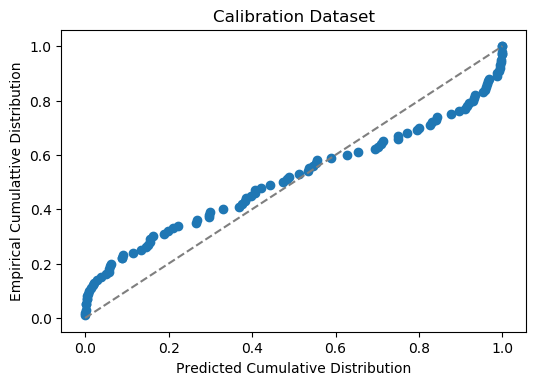

In [10]:
plt.scatter(predicted_percentiles, empirical_percentiles)
plt.plot([0, 1], [0, 1], color='tab:grey', linestyle='--')
plt.xlabel('Predicted Cumulative Distribution')
plt.ylabel('Empirical Cumulattive Distribution')
plt.title('Calibration Dataset');